# This code is intended to be used for offline analysis of the magnetic data retreived from the WebDAQ and Minimus during site surveying.

## You may need to update the widget package to make this work.

## pip install ipywidgets --upgrade
## conda install conda-forge::ipywidgets

## This is used to import the mseed files
## pip install obpy --upgrade
## conda install conda-forge::obspy

# # # Do not run all # # #
# Run one cell at a time or plots may not populate

In [1]:
import obspy
from obspy import UTCDateTime
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider
from ipywidgets import FloatSlider
from ipywidgets import Layout 
from scipy import signal
from matplotlib import gridspec
from scipy.fft import fftshift
import warnings

## This creates a GUI to select the data-file you wish to use
### A program window will appear in your taskbar, this will bring up the GUI
### This is code is intended to run off 3 mseed files, as the minimus creates a file for each direction
## When you have selected your file, close the program window

In [ ]:
####################################################### # # # # # # ############################################################
################################################### # SPAGHETTI CODE # #########################################################
###################################################### # # # # # # # ###########################################################

file_paths_global = [] ###################################### Variable for the data paths ###########################################

################################################# Function to create GUI #######################################################
def upload_files():
    global file_paths_global ################################### makes variable global #########################################
    
    file_paths_global = filedialog.askopenfilenames(title="Select files", filetypes=[("All Files", "*.*")])
    
    if file_paths_global:
        for file_path in file_paths_global:
            print(f"File selected: {file_path}") ######################## Prints out the selected files ########################
    else:
        print("No files selected.")


root = tk.Tk() ######################################## Create the program window ##############################################
root.title("Multi File Uploader")

upload_button = tk.Button(root, text="Upload File", command=upload_files) ######## Create buttons for uploading files #########
upload_button.pack(pady=10)

root.mainloop() ######################################### Runs the application #################################################

################################# sorts paths alphabetically and saves it to a variable ########################################
paths = sorted(file_paths_global) 

# This is where you select the time frame you wish to look at

In [3]:
#################################### Enter the start and end times wish to look at #############################################
'''###############################  start_time = UTCDateTime("2020-01-01T00:00:00")  ########################################'''
#################################### This is an example of how the time should look ############################################

start_time = UTCDateTime("2024-09-29T21:54:07")
end_time = UTCDateTime("2024-09-29T22:30:03")  

# This selects the data requested and sets it to variables

In [ ]:
####################################################### # # # # # # ############################################################
################################################### # SPAGHETTI CODE # #########################################################
###################################################### # # # # # # # ###########################################################

def process_multiple_miniseed(file_paths, start_time=None, end_time=None):
    
    sample_rates_all = []
    times_all = []       ##################################### Variables for the function ######################################
    data_values_all = []
    
    for idx, file_path in enumerate(file_paths):
        print(f"\nProcessing file {idx+1}: {file_path}")
        
        st = obspy.read(file_path) ################################ Reads the MiniSEED file ####################################
    

        if start_time and end_time: ########################## Check and apply time selected time ##############################
            
            print(f"Filtering data between {start_time} and {end_time}")
            st = st.trim(starttime=start_time, endtime=end_time) ############## trims the traces to the same length ############
      
    
        if len(st) == 0: ############################## Check if any traces remain after trimming ##############################
            print(f"No data available in the specified time range for file: {file_path}")
            continue
        

        
        sample_rates = []
        times = []         ############################# lists for the current file's trace(s) #################################
        data_values = []
        
######################################### Process each remaining trace in the file #############################################
        for trace in st:
            
            
            sample_rates.append(trace.stats.sampling_rate) ############# Append trace data to lists for this file ##############
            times.append(trace.times())                    ################## Relative times for each sample ###################
            data_values.append(trace.data)
        
        sample_rates_all.append(sample_rates)
        times_all.append(times)               ########### Append the current file's trace data to the overall lists ############
        data_values_all.append(data_values)
    
########################################### Assign global variables for each file ##############################################
    global sample_rates1, sample_rates2, sample_rates3
    global times1, times2, times3
    global data1, data2, data3
############################################### Assigns variables for each file ################################################
    sample_rates1, sample_rates2, sample_rates3 = sample_rates_all
    times1, times2, times3 = times_all
    data1, data2, data3 = data_values_all
####################################################### Runs function ##########################################################
    
process_multiple_miniseed(paths, start_time=start_time, end_time=end_time)

################################################################################################################################

tim1 = times1[0]
tim2 = times2[0]
tim3 = times3[0]
z = data3[0] * 0.0015e-6
n = data2[0] * 0.0015e-6 ######################## This the conversion factor for turning the data into m/s #####################
e = data1[0] * 0.0015e-6

########################################### This is the sample rate from the metadata ##########################################
sr =  sample_rates1[0]
################################################################################################################################
print("\nSample rate: " + str(sr))
print("\nFinished :D")

## The following cell displays the time series of the recorded data

In [ ]:
plt.figure(figsize = (19, 11))

####################### You can change the linestyle/order in which they are ploted for ease of viewing ########################

plt.plot(tim3,z, linewidth = 1.5, color = 'black', label = 'Z') 
plt.plot(tim2,n, linewidth = 1.5, color = 'red', label = 'N')
plt.plot(tim1,e, linewidth = 1.5, color = 'mediumblue', label = 'E')
#plt.plot(tim,noi, linewidth = 1.5, color = 'yellow', label = 'Noise')

plt.legend(loc = "upper right", fontsize = 18)
plt.title("Seismic Data Time Series", fontweight = 'bold', fontsize = 25)
plt.xlabel("Time [s]", fontweight = "bold", fontsize = 20)
plt.ylabel("Amplitude [m/s]", fontweight = "bold", fontsize = 20)
plt.xlim(0, tim1[len(tim1)-1])
#plt.ylim()
plt.yticks(fontsize = 20, fontweight = "bold")
plt.xticks(fontsize = 20, fontweight = "bold")
plt.grid(True)

#.savefig('**place_img_name_here.format**', bbox_inches='tight')

## If you want to look at a specific time along the time series, you can use the slider plot below. 

### These variables are used to adjust the how many seconds are displayed and the step length

In [7]:
win = 15  ## sec displayed
stepy = 4  ## sec moved

## Beware, there may be a slight time delay when slidering

## If the slider is not workering move to the next cell

In [ ]:
Min = min(z.min(), n.min(), e.min())  ########################## This is to find the window height #############################
Max = max(z.max(), n.max(), e.max())

##################################### This function is what makes the slider run ###############################################
######################################### Parameters can be changed as needed ##################################################

def plot_with_slider(xlim):
    
    plt.figure(figsize=(19, 8))   ## dpi breaks slider
    
    plt.plot(tim3, z, linewidth = 1.5, label = 'Z', color = 'black')
    plt.plot(tim2, n, linewidth = 1.5, label = 'N', color = 'red')
    plt.plot(tim1, e, linewidth = 1.5, label = 'E', color = 'blue')
    
    plt.xlim(xlim, xlim + win) ####################### This is how long the window is (CAN be changed) #########################
    plt.ylim(Min - 1e-5, Max + 1e-5) ################## This adds a buffer to the window height (CAN be changed) #####################
    
    plt.legend(loc = 'upper right', fontsize = 15)
    plt.title("Slider Time Series", fontweight = 'bold', fontsize = 25)
    plt.xlabel("Time [s]", fontweight = "bold", fontsize = 20)
    plt.ylabel("Amplitude [m/s]", fontweight = "bold", fontsize = 20)
    plt.yticks(fontsize = 20, fontweight = "bold")
    plt.xticks(fontsize = 20, fontweight = "bold")
    plt.grid(True)
    plt.show()

######################################## This is where the slider plot gets plotted ############################################
#### min,max = start,end ; step is the increment it slides on ; value is where it starts ; layout is how long the slider is ####
############################################### step and layout CAN be changed #################################################

interact(plot_with_slider, xlim = FloatSlider(min = 0, max = (tim1[len(tim1)-1]), step = stepy, value = 0, 
                                              layout=Layout(width='980px')))


## If you want to look at spectra of specific parts of the time series, you can set the time limits here

## If not, skip the following two cells

In [9]:
################################### Enter how long of a time segment you'd like to look at #####################################
start = 0  ## In terms of seconds
end = 750

## This index the dataframes

In [15]:
alpha = int(start * sr)
beta = int(end * sr)
e1 = e[alpha:beta]
n1 = n[alpha:beta]
z1 = z[alpha:beta]

# These are variables to calculate the ASD and plot limits

In [7]:
##################################################### Plot limits ##############################################################
x_max = 100 ## in terms of frequency
x_min = 5e-2

################################################## Velocity Y limits ###########################################################
y_max = 10e-6 ## in terms of m/s/Hz^0.5
y_min = 50e-10 

################################################ Displacement Y Limits #########################################################
my_max = 10e-7 ## in terms of m/Hz^0.5
my_min = 10e-12

##################################################### fft length ###############################################################
fft_length = 128 ## in terms of seconds

################################################# Precent FFT Overlap ##########################################################
overlap = 50 ## 50% fft overlap

# This cell is where the ASD is calculated and plotted

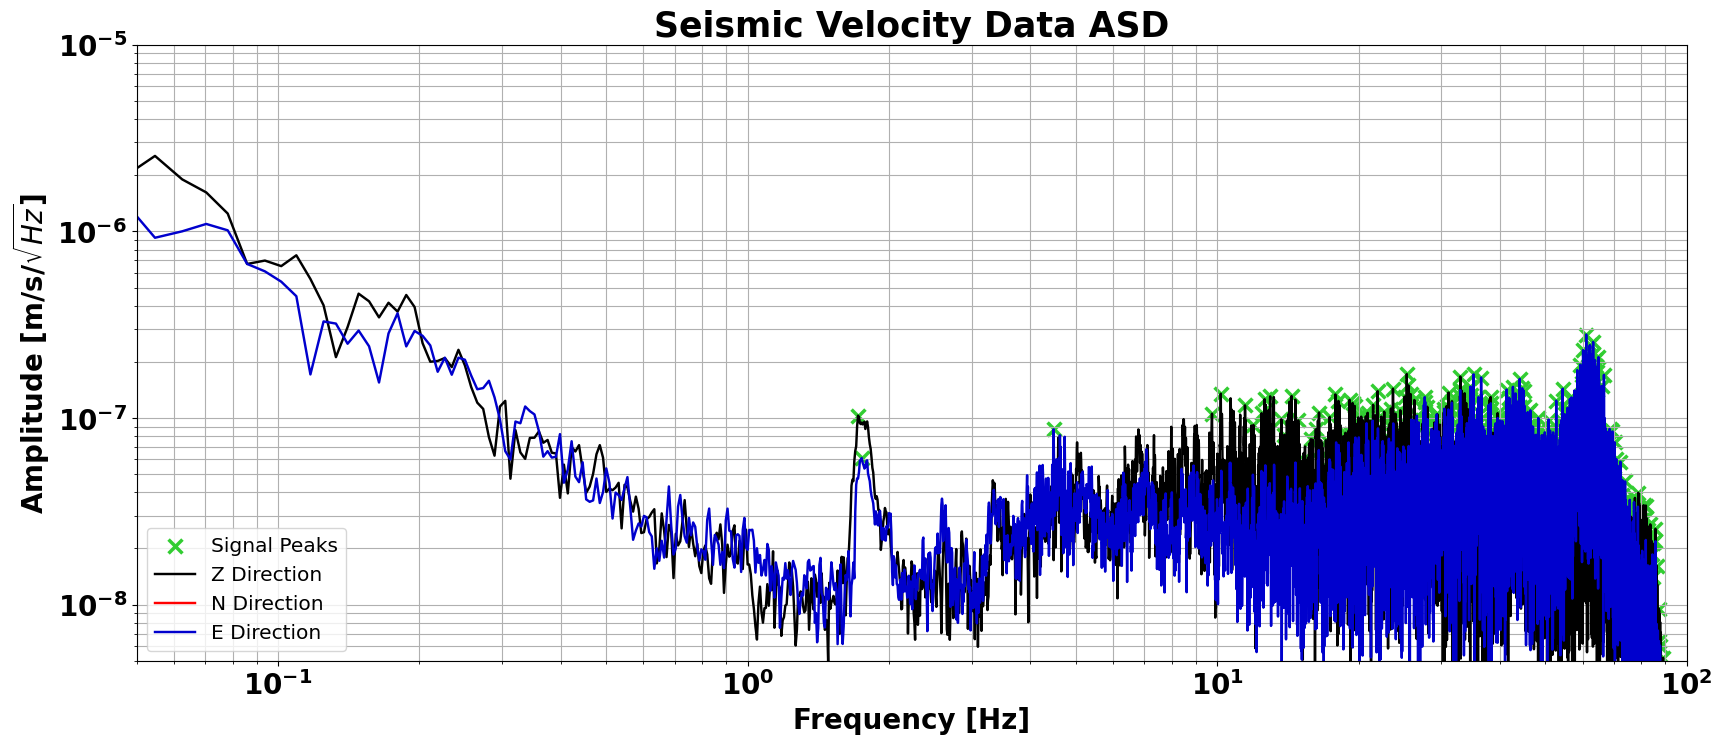

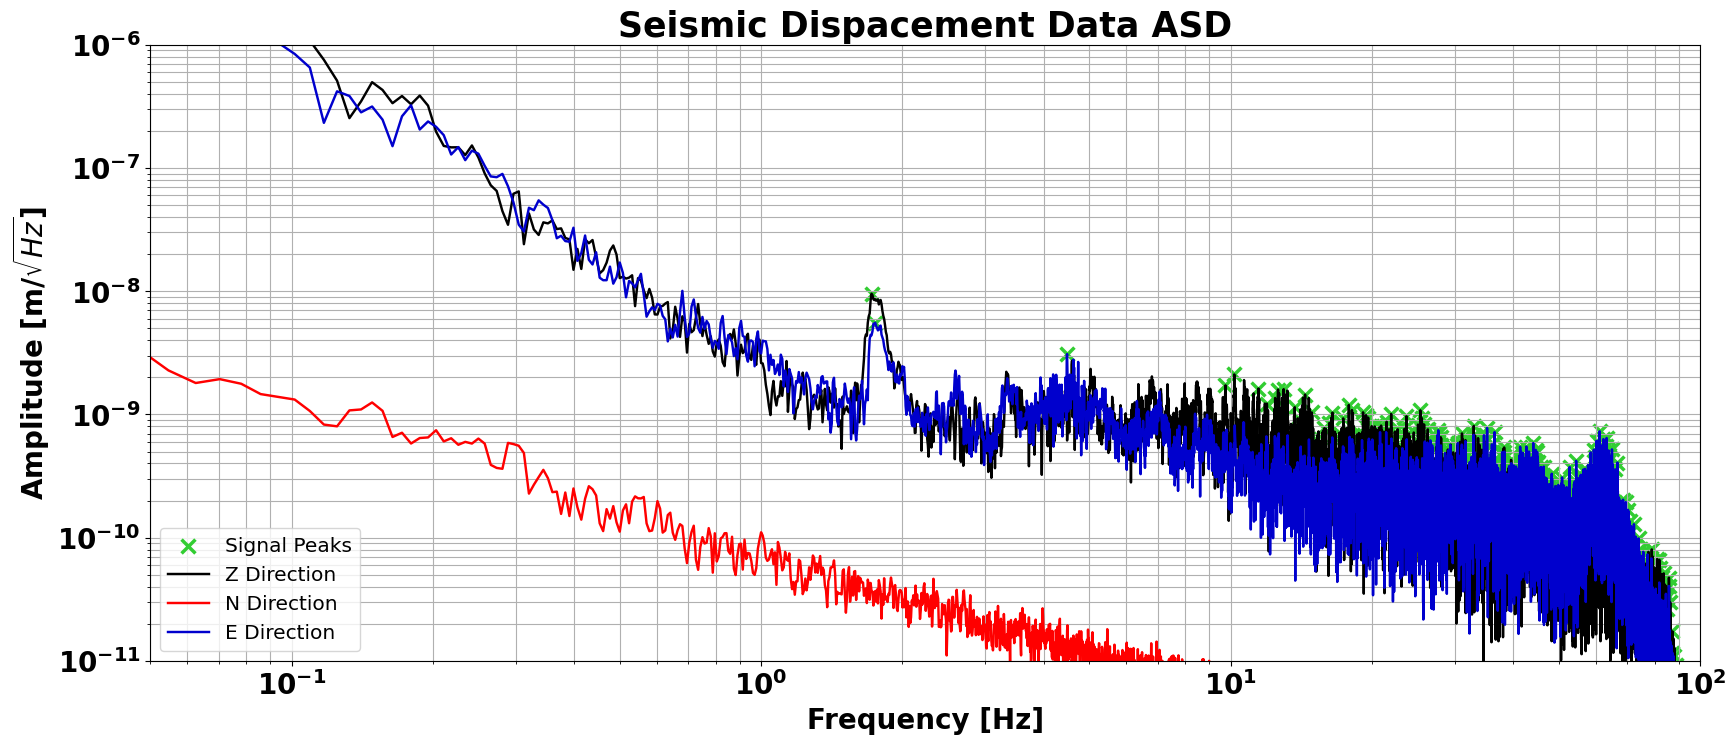

In [13]:
################################################################################################################################
######################################## The PSD is calculated via welch from scipy ############################################
################################################################################################################################
warnings.simplefilter('ignore')

############ If you don't want to look at the whole time series, you can add '1' to the variables, i.e k1, j1, i1 ##############

f_z, Pxx_den_z = signal.welch(z1, sr, window= 'hamming', nperseg= (sr *fft_length), noverlap= round(sr *(overlap *0.01)) )
f_n, Pxx_den_n = signal.welch(n1, sr, window= 'hamming', nperseg= (sr *fft_length), noverlap= round(sr *(overlap *0.01)) )
f_e, Pxx_den_e = signal.welch(e1, sr, window= 'hamming', nperseg= (sr *fft_length), noverlap= round(sr *(overlap *0.01)) )

################### nfft is how long the fft bin lengths, noverlap is bin overlap, window is the window used ###################
####################### We used 100 sec bins, 0.5 sec overlap, and hamming window, these can be changed ########################
################################################ # DO NOT CHANGE/REMOVE 'fs' # #################################################


az = np.sqrt(Pxx_den_z)
an = np.sqrt(Pxx_den_n) ################################ This turns the PSD into an ASD ########################################
ae = np.sqrt(Pxx_den_e)

mz = az / (2*np.pi *f_z)
mn = an / (2*np.pi *f_n) ####################################### Converts m/s to m #############################################
me = ae / (2*np.pi *f_e)


log_z = np.log(az)
log_n = np.log(an) ############### The log of each ASD must be found in order to find the peaks/frequences #####################
log_e = np.log(ae)


peak_z, _ = signal.find_peaks(log_z, prominence = 2) ############### This is where the frequencies are found ###################
peak_n, _ = signal.find_peaks(log_n, prominence = 2) ################ If some are missed or there are extra ####################
peak_e, _ = signal.find_peaks(log_e, prominence = 2) ########### you will need to change the prominence variable ###############



################################################################################################################################
###################################################### PLots data ##############################################################
################################################################################################################################



################################################### Plots Velocity #############################################################
##################################################### Plots Peaks ##############################################################

plt.figure(1, figsize = (20, 8))#, dpi = 2500)

plt.scatter(f_z[peak_z], az[peak_z], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5, label = 'Signal Peaks')
plt.scatter(f_n[peak_n], an[peak_n], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)
plt.scatter(f_e[peak_e], ae[peak_e], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)

#################################################### PLots Spectra #############################################################

plt.yscale('log')
plt.xscale('log')

plt.plot(f_z, az, color = 'black', linewidth = 1.75, label = 'Z Direction')
plt.plot(f_n, an, color = 'red', linewidth = 1.75, label = 'N Direction')
plt.plot(f_e, ae, color = 'mediumblue', linewidth = 1.75, label = 'E Direction')

plt.legend(loc = "lower left", fontsize = 14.5)

plt.title("Seismic Velocity Data ASD", fontweight = 'bold', fontsize = 25)
plt.xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 20)
plt.ylabel("Amplitude [m/s/$\sqrt{Hz}$]", fontweight = "bold", fontsize = 20)

plt.yticks(fontsize = 20, fontweight = "bold")
plt.xticks(fontsize = 20, fontweight = "bold")

plt.ylim(y_min,y_max)
plt.xlim(x_min,x_max)

plt.grid(True, which="both", ls="-")

#plt.savefig('**place_img_name_here.format**', bbox_inches='tight')



################################################# Plots Displacement ###########################################################
##################################################### Plots peaks ##############################################################

plt.figure(2, figsize = (20, 8))#, dpi = 2500)

plt.scatter(f_z[peak_z], mz[peak_z], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5, label = 'Signal Peaks')
plt.scatter(f_n[peak_n], mn[peak_n], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)
plt.scatter(f_e[peak_e], me[peak_e], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)

#################################################### PLots Spectra #############################################################

plt.yscale('log')
plt.xscale('log')

plt.plot(f_z, mz, color = 'black', linewidth = 1.75, label = 'Z Direction')
plt.plot(f_n, mn, color = 'red', linewidth = 1.75, label = 'N Direction')
plt.plot(f_e, me, color = 'mediumblue', linewidth = 1.75, label = 'E Direction')

plt.legend(loc = "lower left", fontsize = 14.5)

plt.title("Seismic Dispacement Data ASD", fontweight = 'bold', fontsize = 25)
plt.xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 20)
plt.ylabel("Amplitude [m/$\sqrt{Hz}$]", fontweight = "bold", fontsize = 20)

plt.yticks(fontsize = 20, fontweight = "bold")
plt.xticks(fontsize = 20, fontweight = "bold")

plt.ylim(my_min,my_max)
plt.xlim(x_min,x_max)

plt.grid(True, which="both", ls="-")

#plt.savefig('**place_img_name_here.format**', bbox_inches='tight')

## The following cell will plot each of direction signal in their own respective plots
### If you don't want/need to look at them individually, you don't have to run it

In [ ]:
################################################################################################################################
############################# This gets plotted as a multipanel plot via gridspec and subplot ##################################
################################################################################################################################

fig = plt.figure(figsize = (20,24))

gs = gridspec.GridSpec(3,1, height_ratios = [1,1,1], hspace = 0.35)

####################################################### Channel Z ##############################################################

axis1 = fig.add_subplot(gs[0,0])

axis1.set_title("Z Direction", fontweight = 'bold' , fontsize = 20)

axis1.set_yscale('log')
axis1.set_xscale('log')

axis1.scatter(f_z[peak_z], az[peak_z], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5, label = 'Signal Peaks')
axis1.plot(f_z, az, color = 'black', linewidth = 1.75, label = 'Z Direction')

axis1.set_xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 18)
axis1.set_ylabel("Amplitude [m/s/$\sqrt{Hz}$]", fontweight = "bold", fontsize = 18)

axis1.tick_params(labelsize=16)

plt.ylim(y_min,y_max)
plt.xlim(x_min,x_max)

axis1.grid(True, which="both", ls="-")

####################################################### Channel N ##############################################################

axis2 = fig.add_subplot(gs[1,0])

axis2.set_title("N Direction", fontweight = "bold", fontsize = 20)

axis2.set_yscale('log')
axis2.set_xscale('log')

axis2.scatter(f_n[peak_n], an[peak_n], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)
axis2.plot(f_n, an, color = 'red', linewidth = 1.75, label = 'N Direction')

axis2.set_xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 18)
axis2.set_ylabel("Amplitude [m/s/$\sqrt{Hz}$]", fontweight = "bold", fontsize = 18)

axis2.tick_params(labelsize=16)

plt.ylim(y_min,y_max)
plt.xlim(x_min,x_max)

axis2.grid(True, which="both", ls="-")

####################################################### Channel E ##############################################################

axis3 = fig.add_subplot(gs[2,0])

axis3.set_title("E Direction", fontweight = "bold", fontsize = 20)

axis3.set_yscale('log')
axis3.set_xscale('log')

axis3.scatter(f_e[peak_e], ae[peak_e], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)
axis3.plot(f_e, ae, color = 'mediumblue', linewidth = 1.75, label = 'E Direction')

axis3.set_xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 18)
axis3.set_ylabel("Amplitude [m/s/$\sqrt{Hz}$]", fontweight = "bold", fontsize = 18)

axis3.tick_params(labelsize=16)

plt.ylim(y_min,y_max)
plt.xlim(x_min,x_max)

axis3.grid(True, which="both", ls="-")

#plt.savefig('**place_img_name_here.format**', bbox_inches='tight')

## The following cells are used to plot spectrograms for each direction

### These variables are to set limits for the plot and to compute the spectrogram

In [21]:
################################################## Colorbar Limits #############################################################
cmin = 10e-10
cmax = 5e-7

##################################################### Plot limits ##############################################################
ymax = 20 ## In terms of frequency
ymin = 0

###################################################### fft length ##############################################################
fft_len = 10 ## in terms of seconds

################################################# Precent FFT Overlap ##########################################################
olap = 50 ## 50% fft overlap

# This is where the spectrograms are plotted

In [ ]:
################################################################################################################################
###################### The spectrograms are calculated with signal.spectrogram from SciPy ######################################
################################################################################################################################
warnings.simplefilter('ignore')

fz, tz, Sxxz = signal.spectrogram(z, sr, window= 'hamming', nperseg=round(sr *fft_len), noverlap= round(sr *(olap *0.01)) )
fn, tn, Sxxn = signal.spectrogram(n, sr, window= 'hamming', nperseg=round(sr *fft_len), noverlap= round(sr *(olap *0.01)) )
fe, te, Sxxe = signal.spectrogram(e, sr, window= 'hamming', nperseg=round(sr *fft_len), noverlap= round(sr *(olap *0.01)) )
#f, t, Sxx = signal.spectrogram(noi, sr, window= 'hamming', nperseg=round(sr *fft_len), noverlap= round(sr *(olap *0.01)) )


fig = plt.figure(figsize = (20,24))

gs = gridspec.GridSpec(4,1, height_ratios = [1,1,1,1], hspace = 0.35)

####################################################### Channel Z ##############################################################

axis1 = fig.add_subplot(gs[0,0])

#m0 = axis1.pcolormesh(tz, fz, np.sqrt(Sxxz), shading='gouraud')############### This will autoscale the plot ###################
                                                                ## If you want to change the limits, uncomment the line below ##
                                                                ########### Be sure to comment out the line above ##############

m0 = axis1.pcolormesh(tz, fz, np.sqrt(Sxxz), shading='gouraud', vmin = cmin, vmax = cmax)

axis1.set_title("Z Direction", fontweight = 'bold' , fontsize = 20)
axis1.set_xlabel('Time [s]', fontweight = 'bold' , fontsize = 18)
axis1.set_ylabel('Frequency [Hz]', fontweight = 'bold' , fontsize = 18)
axis1.tick_params(labelsize=14)

cbar0 = fig.colorbar(m0, pad =0.02)
cbar0.ax.tick_params(labelsize=14)
cbar0.set_label(label='Intensity [m/s/$\sqrt{Hz}$]' ,weight='bold', fontsize = 14)

#axis1.set_ylim(ymin,ymax)   ## Uncomment to set limits


####################################################### Channel N ##############################################################

axis2 = fig.add_subplot(gs[1,0])

#m1 = axis1.pcolormesh(tn, fn, np.sqrt(Sxxn), shading='gouraud')############### This will autoscale the plot ###################
                                                                
m1 = axis2.pcolormesh(tn, fn, np.sqrt(Sxxn), shading='gouraud', vmin = cmin, vmax = cmax)

axis2.set_title("N Direction", fontweight = 'bold' , fontsize = 20)
axis2.set_xlabel('Time [s]', fontweight = 'bold' , fontsize = 18)
axis2.set_ylabel('Frequency [Hz]', fontweight = 'bold' , fontsize = 18)
axis2.tick_params(labelsize=14)

cbar1 = fig.colorbar(m1, pad =0.02)
cbar1.ax.tick_params(labelsize=14)
cbar1.set_label(label='Intensity [m/s/$\sqrt{Hz}$]' ,weight='bold', fontsize = 14)

#axis2.set_ylim(ymin, ymax)   ## Uncomment to set limits

####################################################### Channel E ##############################################################

axis3 = fig.add_subplot(gs[2,0])

#m2 = axis1.pcolormesh(te, fe, np.sqrt(Sxxe), shading='gouraud')############### This will autoscale the plot ###################
                                                                
m2 = axis3.pcolormesh(te, fe, np.sqrt(Sxxe), shading='gouraud', vmin = cmin, vmax = cmax)

axis3.set_title("E Direction", fontweight = 'bold' , fontsize = 20)
axis3.set_xlabel('Time [s]', fontweight = 'bold' , fontsize = 18)
axis3.set_ylabel('Frequency [Hz]', fontweight = 'bold' , fontsize = 18)
axis3.tick_params(labelsize=14)

cbar2 = fig.colorbar(m2, pad =0.02)
cbar2.ax.tick_params(labelsize=14)
cbar2.set_label(label=r'Intensity [m/s/$\sqrt{Hz}$]' ,weight='bold', fontsize = 14)

#axis3.set_ylim(ymin, ymax)   ## Uncomment to set limits


###################################################### Noise Channel ###########################################################
'''
axis4 = fig.add_subplot(gs[3,0])

axis4.set_title("Noise Direction", fontweight = 'bold' , fontsize = 20)

m3 = axis1.pcolormesh(t, f, np.sqrt(Sxx), shading='gouraud') ############### This will autoscale the plot ###################
                                                                
m3 = axis4.pcolormesh(t, f, np.sqrt(Sxx), shading='gouraud', vmin = cmin, vmax = cmax)

axis3.set_title("Electronic Noise", fontweight = 'bold' , fontsize = 20)
axis3.set_xlabel('Time [s]', fontweight = 'bold' , fontsize = 18)
axis3.set_ylabel('Frequency [Hz]', fontweight = 'bold' , fontsize = 18)
axis3.tick_params(labelsize=16)

cbar3 = fig.colorbar(m3, pad = 0.02)
cbar3.ax.tick_params(labelsize=14)
cbar3.set_label(label='Intensity [m/s/$\sqrt{Hz}$]' ,weight='bold', fontsize = 14)


#axis4.set_ylim(ymin, ymax)   ## Uncomment to set limits

#plt.savefig('**place_img_name_here.format**', bbox_inches='tight')
'''
################################################################################################################################
################################## These will take a while to plot, since they are so dense ####################################